In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

experiment_name = "M2"
__RECALLAT__ = 10

In [2]:
class Experimenter:
    def __init__(self, experiment_name):
        self._files = []
        self.experiment_name = experiment_name
    def append(self, recommender_list, forgetting_list, parameters_list):
        for r in recommender_list:
            for p in parameters_list:
                for f in forgetting_list:
                    self._files.append("{}_{}_{}_{}.dat".format(r, f, p, self.experiment_name))
    def __getitem__(self, position):
        return self._files[position]

In [3]:
experimenter = Experimenter(experiment_name)
recommender_list = ["MFRecommender"]
# experimenter.append(recommender_list, ["ForgetUnpopularItems"], [1.2])
# experimenter.append(recommender_list, ["NoForgetting"], [None])
# experimenter.append(recommender_list, ["UserFactorFading"], [0.99])
experimenter.append(recommender_list, ["SDUserFactorFading"], [100])
# experimenter.append(recommender_list, ["MappedUserFactorFading"], [2.])
# experimenter.append(recommender_list, ["MappedUserFactorFading"], [1, 1.1, 1.3, 1.5, 1.8, 2.])

In [4]:
class Recall:
    def __init__(self, n):
        self.n = n
        self.hits = 0
        self.stream = 0 
    def update(self, rank):
        try:
            if rank <= self.n:
                self.hits += 1
            self.stream += 1
            return self.score()
        except Exception as e:
            print("rank: {} n: {}".format(rank, self.n))
            raise e
    def score(self):
        return self.hits/self.stream

In [5]:
# (top-1 score, where the correct item is ranked, rec time, update time)

def getDF(files):
    defined = False
    recallDF = None
    uptimeDF = None
    rectimeDF = None
    for file in files:
        metric = Recall(__RECALLAT__)
        with open("C:\\recsys\\FluRS\\results\\{}".format(file)) as f:
            file = "{} {}".format(file.split("_")[1], file.split("_")[2])
            file = file.replace('.dat','')
            file = file.replace('Recommender_','/')
            data = f.read().split(')')
            data.remove('')
            recallList = []
            uptimeList = []
            rectimeList = []
            indexList = []
            for index, line in enumerate(data):
                line = line.replace('(','')
                line = line.replace(' ','')
                info = line.split(',')
                recallList.append(metric.update(int(info[1])))
                uptimeList.append(float(info[2]))
                rectimeList.append(float(info[3]))
                indexList.append(index)
            if defined:
                recallDF = recallDF.merge(pd.DataFrame({file : recallList, "Index": indexList}), on='Index', how='left')
                uptimeDF = uptimeDF.merge(pd.DataFrame({file : uptimeList, "Index": indexList}), on='Index', how='left')
                rectimeDF = rectimeDF.merge(pd.DataFrame({file : rectimeList, "Index": indexList}), on='Index', how='left')
            else:
                defined = True
                recallDF = pd.DataFrame({"Index": indexList, file : recallList})
                uptimeDF = pd.DataFrame({"Index": indexList, file : uptimeList})
                rectimeDF = pd.DataFrame({"Index": indexList, file : rectimeList})

    recallDF = recallDF.drop(columns=['Index'])
    uptimeDF = uptimeDF.drop(columns=['Index'])
    rectimeDF = rectimeDF.drop(columns=['Index'])
    return recallDF, uptimeDF, rectimeDF

In [6]:
def plot(recallDF, name):
    plt.rcParams['figure.figsize'] = (12,8)
    with plt.style.context(('ggplot')):
        ax = recallDF.plot(lw=2, colormap='jet', marker='.', markersize=1, title=name)
        plt.ylim([0.005,0.015])
        ax.set(xlabel="", ylabel='Recall@{}'.format(__RECALLAT__))
        ax.legend(loc=2, prop={'size': 12})

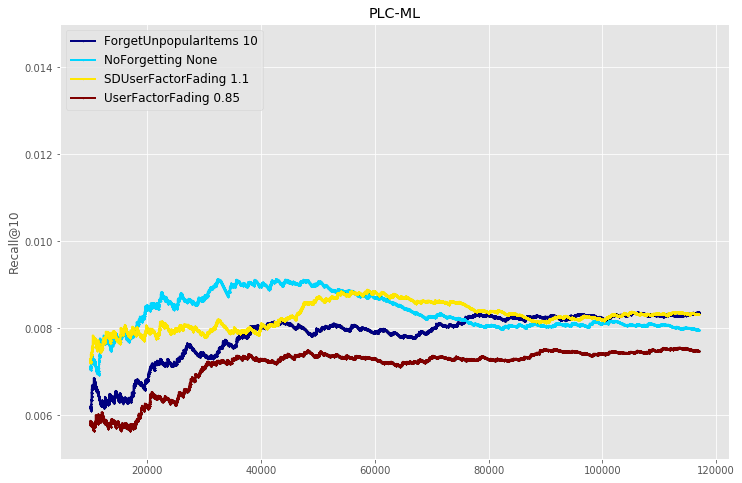

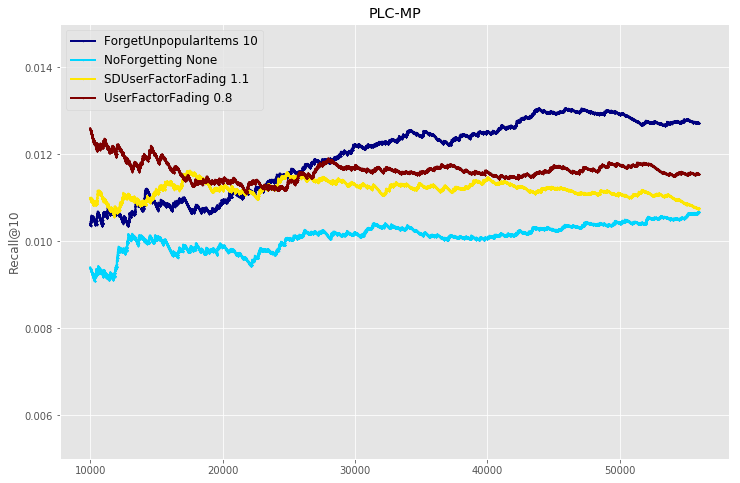

In [7]:
# recallML, uptimeML, rectimeML = getDF(["MFRecommender_ForgetUnpopularItems_1.2_ml-1m-gte.dat", 
# #          "MFRecommender_MappedUserFactorFading_6_ml-1m-gte.dat", 
#          "MFRecommender_NoForgetting_None_ml-1m-gte.dat", 
#          "MFRecommender_SDUserFactorFading_382_ml-1m-gte.dat", 
#          "MFRecommender_UserFactorFading_0.8_ml-1m-gte.dat"])
# plot(recallML[20000:], "MovieLens 1M")

recallMusic, uptimeMusic, rectimeMusic = getDF([
"MFRecommender_ForgetUnpopularItems_10_music_listen_15K.dat",
"MFRecommender_NoForgetting_None_music_listen_15K.dat",
"MFRecommender_SDUserFactorFading_1.1_music_listen_15K.dat",
"MFRecommender_UserFactorFading_0.85_music_listen_15K.dat"]
)

plot(recallMusic[10000:], "PLC-ML-15K")


recallMP, uptimeMP, rectimeMP = getDF(["MFRecommender_ForgetUnpopularItems_10_music_playlist.dat",
"MFRecommender_NoForgetting_None_music_playlist.dat",
"MFRecommender_SDUserFactorFading_1.1_music_playlist.dat",
"MFRecommender_UserFactorFading_0.8_music_playlist.dat"])

plot(recallMP[10000:], "PLC-MP")

In [9]:
# recallMusic.mean() 
# uptimeMusic.mean()
rectimeMusic.mean()

recallAt = [1,5,10,20]

recallML = []
print("PLC-ML")
for r in recallAt:
    print("Calculando com Recall@{}".format(r))
    __RECALLAT__ = r
    recall, _, _ = getDF([
    "MFRecommender_ForgetUnpopularItems_10_music_listen_15K.dat",
    "MFRecommender_NoForgetting_None_music_listen_15K.dat",
    "MFRecommender_SDUserFactorFading_1.1_music_listen_15K.dat",
    "MFRecommender_UserFactorFading_0.85_music_listen_15K.dat"])
    recallML.append(recall)

recallMP = []
print("PLC-MP")
for r in recallAt:
    print("Calculando com Recall@{}".format(r))
    __RECALLAT__ = r    
    recall, _, _ = getDF(["MFRecommender_ForgetUnpopularItems_10_music_playlist.dat",
    "MFRecommender_NoForgetting_None_music_playlist.dat",
    "MFRecommender_SDUserFactorFading_1.1_music_playlist.dat",
    "MFRecommender_UserFactorFading_0.8_music_playlist.dat"])
    recallMP.append(recall)

# recallMP, uptimeMP, rectimeMP

PLC-ML
Calculando com Recall@1
Calculando com Recall@5
Calculando com Recall@10
Calculando com Recall@20
PLC-MP
Calculando com Recall@1
Calculando com Recall@5
Calculando com Recall@10
Calculando com Recall@20


In [14]:
for r in recallML:
    print(r.mean())
print(rectimeMusic.mean())
print(uptimeMusic.mean())


ForgetUnpopularItems 10    0.001328
NoForgetting None          0.001493
SDUserFactorFading 1.1     0.001726
UserFactorFading 0.85      0.001186
dtype: float64
ForgetUnpopularItems 10    0.004212
NoForgetting None          0.004454
SDUserFactorFading 1.1     0.004769
UserFactorFading 0.85      0.003980
dtype: float64
ForgetUnpopularItems 10    0.007776
NoForgetting None          0.008339
SDUserFactorFading 1.1     0.008264
UserFactorFading 0.85      0.007101
dtype: float64
ForgetUnpopularItems 10    0.015452
NoForgetting None          0.015445
SDUserFactorFading 1.1     0.016028
UserFactorFading 0.85      0.014051
dtype: float64
ForgetUnpopularItems 10    0.000056
NoForgetting None          0.000034
SDUserFactorFading 1.1     0.000243
UserFactorFading 0.85      0.000180
dtype: float64
ForgetUnpopularItems 10    0.003249
NoForgetting None          0.003541
SDUserFactorFading 1.1     0.003423
UserFactorFading 0.85      0.003506
dtype: float64
